In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

In [31]:
# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
  os.makedirs(FLAGS.log_dir)

In [32]:
# Step 1: Download the data.
'''
url = 'http://mattmahoney.net/dc/'


# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  local_filename = os.path.join(gettempdir(), filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
  return local_filename


filename = maybe_download('text8.zip', 31344016)
'''
filename = "/Users/allen.wu/Desktop/data/text8.zip"
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    #print(tf.compat.as_str(f.read(f.namelist()[0])).split())
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data


vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 204499


In [33]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 4000


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary


# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
print('Length of dictionary:', len(dictionary))
print('Length of reverse_dictionary:', len(reverse_dictionary))
data_index = 0


Most common words (+UNK) [['UNK', 294], ('1023406', 25723), ('1054872', 8097), ('1064830', 7618), ('1027019', 7099)]
Sample data [54, 872, 2, 3003, 82, 4, 39, 5, 1, 36] ['1085818', '1008032', '1054872', '1022854', '1118137', '1027019', '1131534', '1050642', '1023406', '1047875']
Length of dictionary: 4000
Length of reverse_dictionary: 4000


In [34]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

872 1008032 -> 54 1085818
872 1008032 -> 2 1054872
2 1054872 -> 872 1008032
2 1054872 -> 3003 1022854
3003 1022854 -> 2 1054872
3003 1022854 -> 82 1118137
82 1118137 -> 4 1027019
82 1118137 -> 3003 1022854


In [35]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

In [36]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # Open a writer to write summaries.
  writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0
   
   
    
    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
    for i in xrange(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()


Initialized
Average loss at step  0 :  195.23263549804688
Nearest to 1010748: 1037874, 1052153, 1126624, 1006702, 1053173, 1123887, 1094353, 1138754,
Nearest to 1059160: 1010490, 1123514, 1026734, 1132075, 1101724, 1095605, 1050363, 1137546,
Nearest to 1001264: 721, 1105113, 1137596, 1026355, 1085128, 1042164, 1111415, 1101592,
Nearest to 1051820: 1026036, 1076183, 1121005, 1089899, 1010342, 1043934, 1122644, 1061189,
Nearest to 1126690: 1097627, 1117926, 1011970, 1117759, 1102949, 1119898, 1033116, 1006425,
Nearest to 782: 1016229, 1137609, 1079839, 1097436, 1042332, 1035923, 1111538, 1043156,
Nearest to 1002591: 1106948, 1076600, 1008671, 1028929, 1076281, 1111518, 1118858, 1048633,
Nearest to 1020317: 1077663, 1071516, 1096021, 1017451, 1024988, 1028576, 844, 1105113,
Nearest to 1039925: 1126629, 1122998, 1063240, 1065383, 900, 1126698, 1125460, 1136968,
Nearest to 1097655: 1031589, 1077701, 1134609, 1066166, 1037941, 1104710, 1023530, 1097771,
Nearest to 1054872: 1118951, 1137487, 

Average loss at step  42000 :  4.443614683508873
Average loss at step  44000 :  4.428427107930183
Average loss at step  46000 :  4.426068549156189
Average loss at step  48000 :  4.421427696704865
Average loss at step  50000 :  4.409940727233887
Nearest to 1010748: 1053173, 1054685, 1126624, 1136715, 1125679, 1092167, 1132446, 1023406,
Nearest to 1059160: 1064243, 1079769, 1124126, 1123514, 1083338, 1116203, 1122724, 1008538,
Nearest to 1001264: 1026355, 1136916, 1042164, 1012919, 1136867, 1115759, 1117753, 1121591,
Nearest to 1051820: 1076183, 1039942, 1110614, 1064731, 1054398, 1115988, 1043934, 1088307,
Nearest to 1126690: 2380, 1117291, 1136916, 1124914, 1102949, 1021189, 1029627, 1126687,
Nearest to 782: 1035923, 1096285, 1068562, 1079839, 1137609, 1041552, 1094579, 1057677,
Nearest to 1002591: 1076600, 1105296, 1078321, 1023406, 1024224, 1028929, 1031853, 1131783,
Nearest to 1020317: 1029600, 1135182, 1082148, 844, 1003876, 1136146, 1077663, 1020316,
Nearest to 1039925: 900, 11201

Average loss at step  92000 :  4.318675346374512
Average loss at step  94000 :  4.31990579533577
Average loss at step  96000 :  4.315591094732285
Average loss at step  98000 :  4.307491521477699
Average loss at step  100000 :  4.3092498874664305
Nearest to 1010748: 1092167, 1053173, 1046053, 1067566, 1125679, 1044349, 1027019, 1137023,
Nearest to 1059160: 1064243, 1079769, 1124126, 1008538, 1122724, 1039942, 1083338, 1015626,
Nearest to 1001264: 1026355, 1030939, 1136916, 1136867, 1083276, 1107436, 1099870, 1042164,
Nearest to 1051820: 1039942, 1076183, 1110614, 1111491, 1064731, 1043934, 1054398, 1114154,
Nearest to 1126690: 1124914, 1126687, 1101671, 2380, 1136916, 1029627, 1021189, 1045117,
Nearest to 782: 1096285, 1079839, 1035923, 1068562, 1064275, 1094579, 1057677, 1137609,
Nearest to 1002591: 1105296, 1095060, 1024224, 1131783, 1078321, 1048633, 1076600, 1124723,
Nearest to 1020317: 1029600, 844, 1009709, 1065073, 1135182, 1055398, 1003876, 1137589,
Nearest to 1039925: 900, 1111

In [88]:
# Step 6: Visualize the embeddings.


# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    country = publisher_id_name_map.get(label)
    if country == None:
        continue
    color = '#808080'
    if country != None:
        if 'US' in country:
            color = '#ff0000'
        elif 'FR' in country:
            color = '#0000ff'
        elif 'IL' in country:
            color = '#00ff00'
        elif 'GB' in country:
            color = '#800080'
        elif 'NZ' in country:
            color = '#800000'
        elif 'DE' in country:
            color = '#ffa500'
        elif 'IN' in country:
            color = '#ffe4c4'
        elif 'AU' in country:
            color = '#6495ed'
        elif 'IT' in country:
            color = '#ff1493'
        elif 'CA' in country:
            color = '#adff2f'
        elif 'MY' in country:
            color = '#778899'
    label = str(label)+" -"+str(country)
    plt.scatter(x, y, c=color)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)


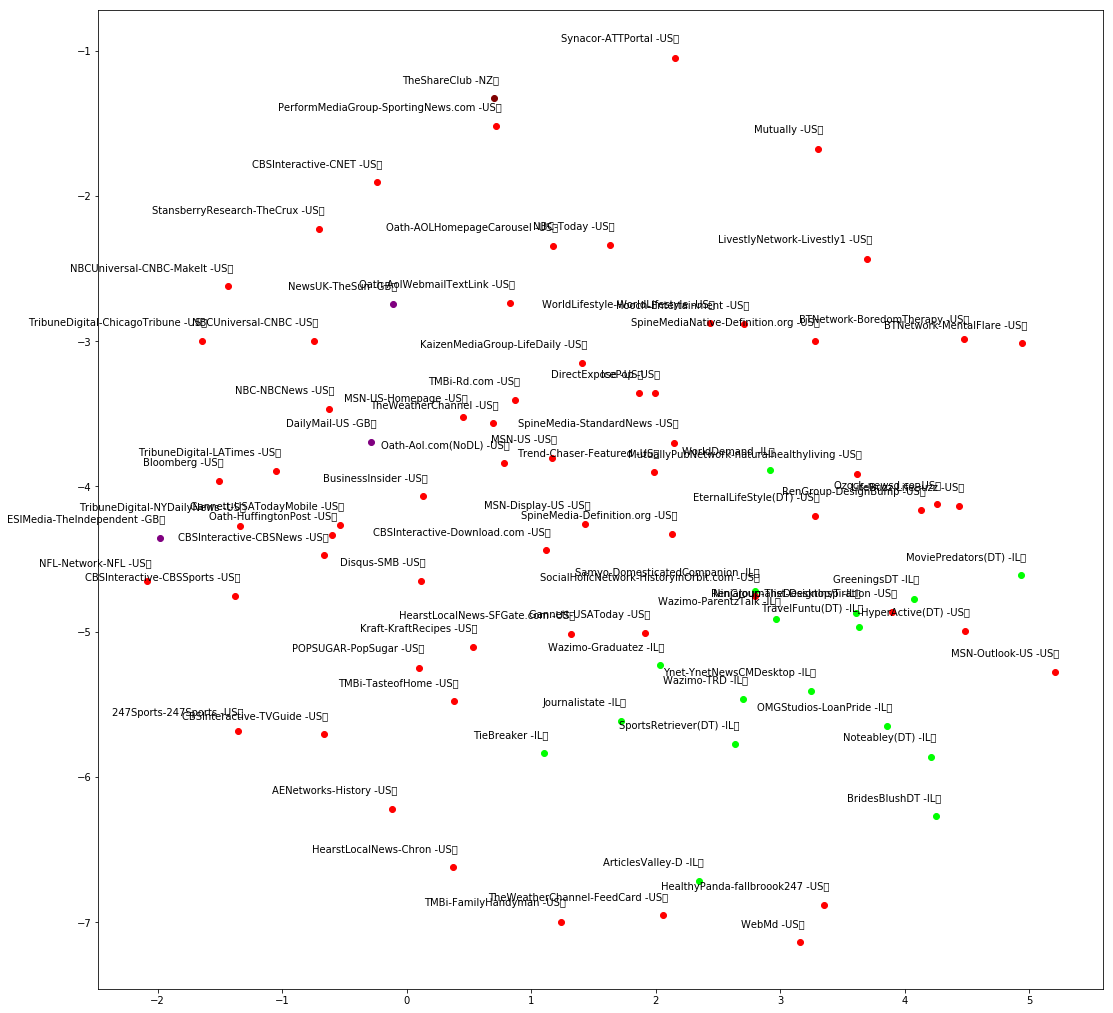

In [89]:
try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  %matplotlib inline
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 100
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)


In [59]:
filename = "/Users/allen.wu/Desktop/publisher_country.csv"

def read_publisher_id_list(csv_file):
    publisher_id_name_map = {}
    with open(csv_file, "r") as f:
        content = f.readlines()
        for line in content:
            tokens = line.split(",")
            id = tokens[0]
            name = tokens[1]
            country = tokens[2]
            publisher_id_name_map[id] = country
    f.close()
    return publisher_id_name_map

publisher_id_name_map = read_publisher_id_list(filename)
print('publisher_id_name_map length:', str(len(publisher_id_name_map)))
for publisher in publisher_id_name_map:
    country = publisher_id_name_map.get(publisher)
    print('id:', publisher)
    print('country:', country)
    break

publisher_id_name_map length: 118876
publisher: TribuneMedia-AppAndroid-WHO\|DesMoines
country: US



In [8]:
filename = "/Users/allen.wu/Desktop/data/results-20180713-161836.csv"

def read_publisher_ratio_list(csv_file):
    publisher_map = {}
    with open(csv_file, "r") as f:
        content = f.readlines()
        for line in content:
            tokens = line.split(",")
            id = tokens[0]
            name = tokens[1]
            category = tokens[3]

            publisher_map[id] = (name, category)
    f.close()
    return publisher_map

publisher_map = read_publisher_ratio_list(filename)
print('publisher_map length:', str(len(publisher_map)))
for publisher in publisher_map:
    name, category = publisher_map.get(publisher)
    print('publisher:', publisher)
    print('name:', name)
    print('category:', category)
    break

publisher_map length: 365
publisher: 1014029
name: yahoojp-afpbbcom
category: news


In [14]:
# Step 6: Visualize the embeddings.


# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_category(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  count = 0
  category_count = {}
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    value = publisher_map.get(label)
    name=""
    category=""
    if publisher_map.get(label) != None:
        name, category = publisher_map.get(label)
    else:
        continue
    color = '#808080'
    if category != None:
        category_count[category]+=1
        if 'sports' in category:
            color = '#ff0000'
        elif 'art and entertainment' in category:
            color = '#ffa500'
    label = ""
    if count < 100:
        label = str(name)+" -"+str(category)
        count +=1
        
    plt.scatter(x, y, c=color)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
    
  for category in category_count:
    print(str(category))

  plt.savefig(filename)

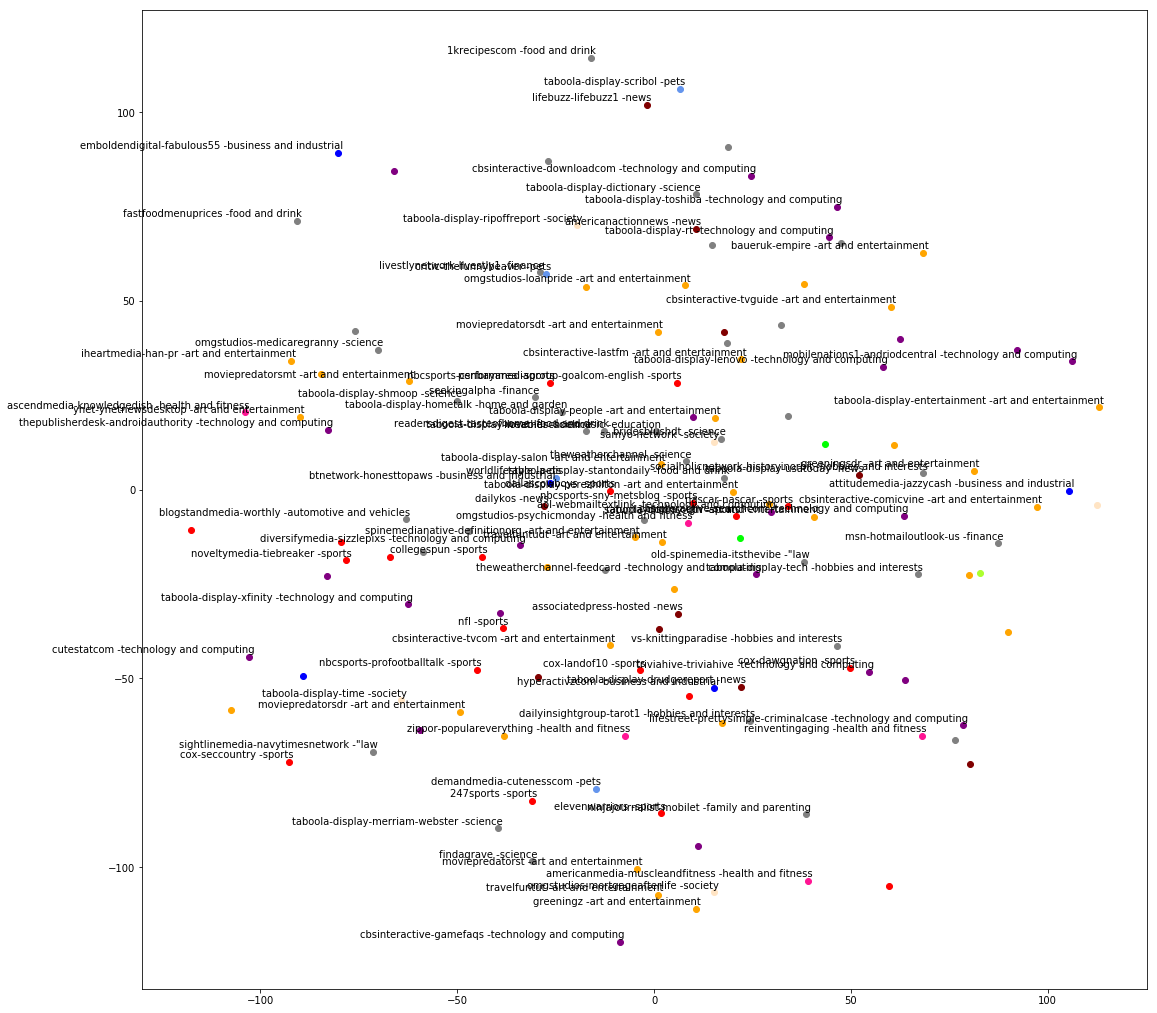

In [17]:
try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  %matplotlib inline
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 2000
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_category(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne1.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)


In [43]:
print(len(final_embeddings))
labels = [reverse_dictionary[i] for i in xrange(len(final_embeddings))]
print(len(final_embeddings))
file = open("/Users/allen.wu/Desktop/publisher_embedding.txt", "w")
for i, embedding in enumerate(final_embeddings):
    if i == 0:
        continue
    file.writelines(str(labels[i])+"\t"+str(embedding))
file.close()

4000
4000
